In [1]:
import numpy as np 
import pandas as pd
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras


2021-10-07 16:08:47.798466: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
train_path= '../input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
validation_path='../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'
test_path='../input/face-mask-12k-images-dataset/Face Mask Dataset/Test'

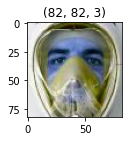

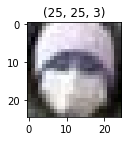

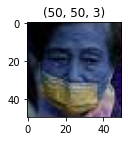

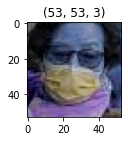

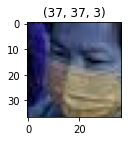

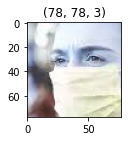

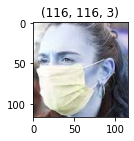

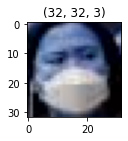

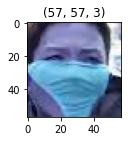

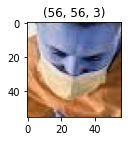

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

Sortedimagespath = sorted(os.listdir(train_path+'/WithMask'))

for i in range(10):
    im=(cv2.imread("../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithMask/" + Sortedimagespath[i]))
    f=plt.figure(figsize=(20, 5))
    f.add_subplot(1,10,i+1)
    plt.imshow(im)
    plt.title(im.shape)
    plt.show()

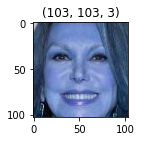

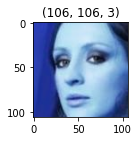

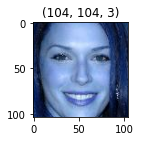

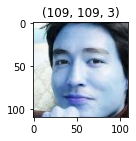

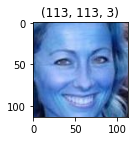

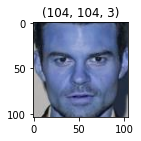

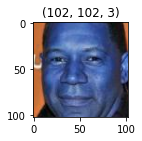

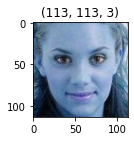

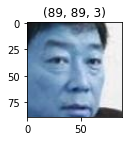

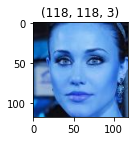

In [4]:
womask = sorted(os.listdir(train_path+'/WithoutMask'))

for i in range(10):
    im=(cv2.imread("../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithoutMask/" + womask[i]))
    
    f=plt.figure(figsize=(20, 7))
    f.add_subplot(1,10,i+1)
    plt.imshow(im)
    plt.title(im.shape)
    plt.show()

In [5]:
target_size=(256,256)
batch_size = 64

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


In [7]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary')



Found 10000 images belonging to 2 classes.


In [9]:
validation_generator = test_datagen.flow_from_directory(
    validation_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary')



Found 800 images belonging to 2 classes.


In [10]:

test=ImageDataGenerator(rescale=1. / 255,)
test_images=test.flow_from_directory(
    test_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 992 images belonging to 2 classes.


In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [12]:
bModel = MobileNetV2(weights="imagenet", include_top=False,input_shape=[256,256,3])

2021-10-07 16:09:03.436462: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-07 16:09:03.439507: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-07 16:09:03.486535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 16:09:03.487162: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-07 16:09:03.487227: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-07 16:09:03.511792: I tensorflow/stream_executor/platform/def

9412608/9406464 [==============================] - 0s 0us/step


In [13]:
headModel = bModel.output
headModel = AveragePooling2D(pool_size=(3,3))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

In [14]:
model = Model(inputs=bModel.input, outputs=headModel)

In [15]:
for layer in bModel.layers:
	layer.trainable = False
    

In [16]:
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1)

In [17]:
for layer in bModel.layers:
	layer.trainable = False
    

In [18]:
opt = Adam(lr=0.001, decay=0.001/50)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [19]:
history=model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint],
    verbose=1
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-10-07 16:09:08.358297: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-07 16:09:08.361960: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000185000 Hz


Epoch 1/20


2021-10-07 16:09:10.786426: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-07 16:09:11.635673: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-07 16:09:12.134052: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


157/157 [==============================] - 219s 1s/step - loss: 0.3012 - accuracy: 0.8997 - val_loss: 0.0240 - val_accuracy: 0.9937

Epoch 00001: accuracy improved from -inf to 0.95130, saving model to best_model.hdf5
Epoch 2/20
157/157 [==============================] - 163s 1s/step - loss: 0.0686 - accuracy: 0.9748 - val_loss: 0.0219 - val_accuracy: 0.9937

Epoch 00002: accuracy improved from 0.95130 to 0.97680, saving model to best_model.hdf5
Epoch 3/20
157/157 [==============================] - 166s 1s/step - loss: 0.0569 - accuracy: 0.9778 - val_loss: 0.0153 - val_accuracy: 0.9937

Epoch 00003: accuracy improved from 0.97680 to 0.97880, saving model to best_model.hdf5
Epoch 4/20
157/157 [==============================] - 166s 1s/step - loss: 0.0579 - accuracy: 0.9802 - val_loss: 0.0333 - val_accuracy: 0.9887

Epoch 00004: accuracy improved from 0.97880 to 0.98260, saving model to best_model.hdf5
Epoch 5/20
157/157 [==============================] - 167s 1s/step - loss: 0.0416 - ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


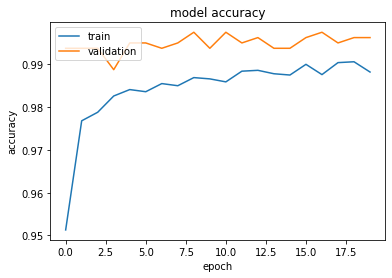

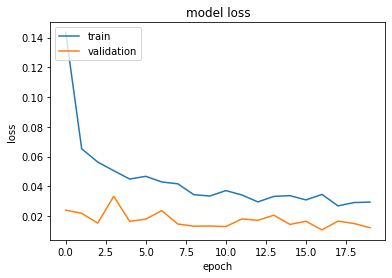

In [20]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
from tensorflow.keras.models import load_model 
finalmodel = load_model('best_model.hdf5')

In [22]:
score = finalmodel.evaluate(test_images, verbose = 1)

16/16 [==============================] - 8s 457ms/step - loss: 0.0149 - accuracy: 0.9950


In [23]:
score


[0.014858882874250412, 0.9949596524238586]

In [24]:
finalmodel.save("model.h5")